# Data Integration

The integration script is for reference only and the integrated dataframe can be downloaded with the link: %

In [ ]:
# import os, re, sys
# import fcsparser
# import pandas as pd

# sys.path.insert(0, '../..')
# from scripts.aux_functions import *

In [ ]:
# Import raw data
# base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure3_4-S3_S4/WNT-EGF Competition"
# os.makedirs(f"{base_dir}/output", exist_ok=True)
# input_dir = f"{base_dir}/preprocessed_data"
# output_dir = f"{base_dir}/output"

# filelist = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
# filelist


In [ ]:
# ---
# Integration
# ---

# Naming convention:
# batch_experiment_barcode_reagent1-concentration1_reagent2-concentration2_replicate
# e.g. "B0_WNT-EGF_001_WNT-0_EGF-0_1.txt"

# integrated = pd.DataFrame()
# for f in filelist:
#     df_new = pd.read_csv(f"{input_dir}/{f}", sep="\t")
#     df_new = df_new.rename(
#         columns=lambda x: re.sub("_v[0-9]+$", "", x)
#     )  # Revome the version number etc.

#     batch = f.split("_")[0]
#     barcode = f.split("_")[2]

#     treatment_1 = f.split("_")[3]
#     reagent_1 = treatment_1.split("-")[0]
#     concentration_1 = treatment_1.split("-")[1]
#     treatment_2 = f.split("_")[4]
#     reagent_2 = treatment_2.split("-")[0]
#     concentration_2 = treatment_2.split("-")[1]

#     replicate = f.split("_")[-1].split(".")[0]

#     df_new["batch"] = batch
#     df_new["barcode"] = barcode

#     df_new["treatment_1"] = treatment_1
#     df_new["reagent_1"] = reagent_1
#     df_new["concentration_1"] = concentration_1
#     df_new["treatment_2"] = treatment_2
#     df_new["reagent_2"] = reagent_2
#     df_new["concentration_2"] = concentration_2

#     df_new["replicate"] = replicate
#     df_new["culture"] = treatment_1 + "_" + treatment_2
#     df_new["condition"] = treatment_1 + "_" + treatment_2 + "_" + replicate

#     # WNT/EGF concentration
#     if reagent_1 == "WNT":
#         WNT = treatment_1
#         WNT_conc = int(concentration_1)
#     elif reagent_2 == "WNT":
#         WNT = treatment_2
#         WNT_conc = int(concentration_2)
#     else:
#         WNT = "WNT-0"
#         WNT_conc = 0
#     df_new["WNT"] = WNT
#     df_new["WNT_Conc"] = WNT_conc

#     if reagent_1 == "EGF":
#         EGF = treatment_1
#         EGF_conc = int(concentration_1)
#     elif reagent_2 == "EGF":
#         EGF = treatment_2
#         EGF_conc = int(concentration_2)
#     else:
#         EGF = "EGF-0"
#         EGF_conc = 0
#     df_new["EGF"] = EGF
#     df_new["EGF_Conc"] = EGF_conc

#     df_new["WNT_EGF_Ratio"] = WNT_conc / EGF_conc if (EGF_conc != 0) else "-"
#     df_new["EGF_WNT_Ratio"] = EGF_conc / WNT_conc if (WNT_conc != 0) else "-"

#     integrated = pd.concat([integrated, df_new])
# integrated.head()
# integrated.shape

# integrated.columns.values
# integrated.to_csv(f"{output_dir}/integrated_dataframe_all-cells.csv", index=False)


# EMD Calculation

In [1]:
import os, sys
import pandas as pd
import scprep
from scipy.stats import zscore

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts.__init__ import non_marker

In [2]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure3-4_S3-S4/WNT-EGF Competition"
os.makedirs(f"{base_dir}/output/emd", exist_ok=True)
output_dir = f"{base_dir}/output/emd"

# NB: integrated dataframe can be accessed at <10.5281/zenodo.7586958>
input_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Data Share/CyTOFdataframes"

In [4]:
# Generate full_panel and metadata_columns on the fly
df = pd.read_csv(f"{input_dir}/WNT-EGF-Competition_all-cells.csv")
df_columns = df.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))

# EMD calculation
# Import raw data and perform arcsinh transformation
subset = "all-cells"
subset_df = pd.read_csv(f"{input_dir}/WNT-EGF-Competition_{subset}.csv")
# Arcsinh transformation
subset_df = arcsinh_transf(subset_df, full_panel, 5)

#! Set reference for EMD calculation
emd_ref = subset_df.loc[subset_df["culture"] == f"WNT-0_EGF-0"]  # for all cells

# EMD calculation
emd_df = pd.DataFrame()
emd_df_master = pd.DataFrame()
emd_infodict = {}

# Get all experimental conditions for which EMD is going to be calculated
conditions = subset_df["condition"].unique().tolist()
len(conditions)


# Compute EMD and compile the result in a master dataframe
for condition in conditions:
    compare_from = subset_df.loc[subset_df["condition"] == condition]
    df = calculate_emd(
        full_panel,  # all antibody measurements
        compare_from,
        emd_ref,  #!
        metadata_columns,
        emd_df,
        emd_infodict,
    )
    emd_df_master = pd.concat([emd_df_master, df])
emd_df_master.head()


# Long to wide transformation
emd_df_master_wide = emd_df_master.pivot_table(
    index=metadata_columns,
    columns="marker",
    values="EMD_arc",
).reset_index()

emd_df_master_wide.head()
emd_df_master_wide.to_csv(
    f"{output_dir}/emd_df_master_{subset}_no-norm.csv",
    index=False,
)

# WNT-EGF Gradient

In [3]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../..') # Add the script folder to the path
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure3-4_S3-S4/WNT-EGF Competition"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
subset = "all-cells"
norm = "no-norm" # no-norm

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide = emd_df_master_wide[
    (emd_df_master_wide["WNT"] == "WNT-0") | (emd_df_master_wide["EGF"] == "EGF-0")
]  # Keep WNT only or EGF only conditions

set(emd_df_master_wide["culture"])


{'EGF-10_WNT-0',
 'EGF-25_WNT-0',
 'EGF-40_WNT-0',
 'EGF-50_WNT-0',
 'WNT-0_EGF-0',
 'WNT-100_EGF-0',
 'WNT-10_EGF-0',
 'WNT-20_EGF-0',
 'WNT-50_EGF-0'}

<IPython.core.display.Javascript object>

In [6]:
# Define markers used for PCA
dr_panel = [
    # cell-type
    "111Cd_CD44",
    # "113In_CEACAM1_CD66a",
    # "115In_Pan-CK",
    # "116Cd_GFP",
    "143Nd_C-MYC_1",
    "162Dy_LRIG1_1",
    "169Tm_EPHB2",
    "171Yb_SOX9_5",
    "174Yb_Clusterin_1",
    "175Lu_Survivin_2",
    "176Yb_FABP2",
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)

<IPython.core.display.Javascript object>

## PHATE

In [7]:
#---
# PHATE
#---

phate_operator = phate.PHATE(
    knn=10, t=5, random_state=42, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)

# Adjust the plotting order
Y_phate_df_control = Y_phate_df.loc[Y_phate_df["culture"] == "WNT-0_EGF-0"]
Y_phate_df_egf = Y_phate_df.loc[Y_phate_df["culture"] == "EGF-50_WNT-0"]
Y_phate_df_wnt = Y_phate_df.loc[Y_phate_df["culture"] == "WNT-100_EGF-0"]

Y_phate_df_other = Y_phate_df.loc[
    -Y_phate_df["culture"].isin(["WNT-0_EGF-0", "EGF-50_WNT-0", "WNT-100_EGF-0"])
]
Y_phate_df = pd.concat(
    [Y_phate_df_other, Y_phate_df_egf, Y_phate_df_wnt, Y_phate_df_control]
)

<IPython.core.display.Javascript object>

### WNT-EGF Gradient

(-0.23328256869056463,
 0.2590468298913552,
 -0.04827928467580511,
 0.0765997137155742)

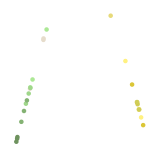

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(1,1, figsize=(1.8, 1.8))
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=Y_phate_df.loc[:, "culture"],
    cmap=colours,
    ticks=True,
    s=5,
    label_prefix="PHATE",
    legend=False,
    fontsize=7,
    ax=ax,
)
fig.axis("off")

### CLU, SURVIVIN, Pan-CK, and pRB [S801/811]

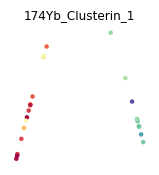

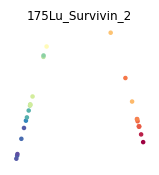

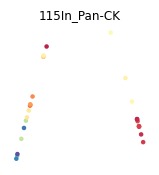

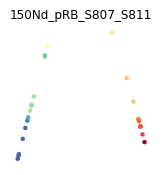

<IPython.core.display.Javascript object>

In [9]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2", "115In_Pan-CK", "150Nd_pRB_S807_S811"]:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PHATE_WNT-EGF-Gradient_{marker}.pdf",
    #     bbox_inches="tight",
    #     )


## PCA

In [10]:
# ---
# PCA
# ---

pca = PCA(n_components=2)
pca.fit(dr_matrix)

Y_pca = pca.transform(dr_matrix)
pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)  # %variance explained
pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)

# Join PCA coordinates with EMD dataframe
Y_pca_df = pd.DataFrame(Y_pca).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_pca_df = pd.merge(emd_df_master_wide, Y_pca_df, on="index")
Y_pca_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_pca_df.head()

,batch,barcode,treatment_1,reagent_1,concentration_1,treatment_2,reagent_2,concentration_2,replicate,culture,...,174Yb_Clusterin_1,175Lu_Survivin_2,176Yb_FABP2,191Ir_DNA 1,193Ir_DNA 2,194Pt_Cisplatin,209Bi_DiMeHH3_K4,89Y_pHH3_S28,0,1
0,B1,1,WNT-0,WNT,0,EGF-0,EGF,0,1,WNT-0_EGF-0,...,-0.191280,-0.031790,-0.058681,-0.047304,-0.046100,-0.143317,-0.118408,0.017210,0.301011,0.443942
1,B1,2,WNT-0,WNT,0,EGF-0,EGF,0,2,WNT-0_EGF-0,...,0.061850,0.023246,0.073919,0.053632,0.055607,0.128847,0.098753,0.015404,0.221665,0.118102
2,B1,3,WNT-0,WNT,0,EGF-0,EGF,0,3,WNT-0_EGF-0,...,0.178683,0.020712,0.067817,0.044777,0.043871,0.053291,0.070116,0.010988,0.376584,0.011883
3,B1,7,WNT-100,WNT,100,EGF-0,EGF,0,1,WNT-100_EGF-0,...,0.667126,-0.204921,-0.374759,-0.040943,-0.039763,-0.639508,-0.598422,0.065094,1.301675,-0.027926
4,B1,8,WNT-100,WNT,100,EGF-0,EGF,0,2,WNT-100_EGF-0,...,0.677499,-0.184424,-0.447293,-0.079882,-0.076649,-0.482239,-0.589128,0.054427,1.223260,-0.080681


<IPython.core.display.Javascript object>

### WNT-EGF Gradient

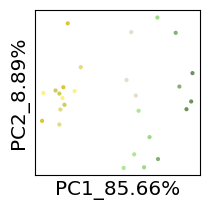

<IPython.core.display.Javascript object>

In [13]:
fig = scprep.plot.scatter2d(
    Y_pca_df.iloc[:, -2:],
    c=Y_pca_df.loc[:, "culture"],
    cmap=colours,
    ticks=False,
    xlabel=f"PC1_{pc1}%",
    ylabel=f"PC2_{pc2}%",
    s=4,
    legend=False,
    figsize=(2.2, 2.2),
)   

### CLU, SURVIVIN, Pan-CK, and pRB [S801/811]

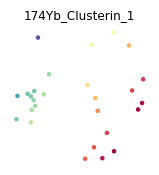

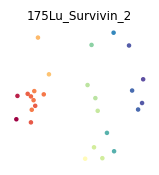

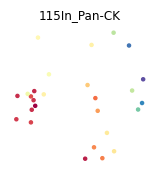

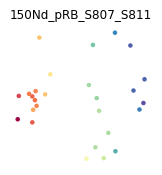

<IPython.core.display.Javascript object>

In [14]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2", "115In_Pan-CK", "150Nd_pRB_S807_S811"]:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")


# WNT-EGF Competition

In [23]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../..') # Add the script folder to the path
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [24]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure3-4_S3-S4/WNT-EGF Competition"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
subset = "all-cells"
norm = "no-norm" # no-norm

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide_extreme = emd_df_master_wide[
    (emd_df_master_wide["culture"] == "WNT-100_EGF-0")
    | (emd_df_master_wide["culture"] == "EGF-50_WNT-0")
    | (emd_df_master_wide["culture"] == "WNT-0_EGF-0")
]  # Controls and WNT/EGF mono treatments
emd_df_master_wide = emd_df_master_wide[
    (emd_df_master_wide["WNT_EGF_Ratio"] != "-")
    & (emd_df_master_wide["EGF_WNT_Ratio"] != "-")
]  # Removes WNT/EGF mono treatments
emd_df_master_wide = pd.concat([emd_df_master_wide_extreme, emd_df_master_wide])

for i, r in emd_df_master_wide.iterrows():
    if (r["WNT"] == "WNT-0") & (r["EGF"] == "EGF-0"):
        emd_df_master_wide.at[
            i, "EGF_WNT_Ratio"
        ] = "--"  # Label controls for colour palette


<IPython.core.display.Javascript object>

In [25]:
# Define markers used for PCA
dr_panel = [
    # cell-type
    "111Cd_CD44",
    # "113In_CEACAM1_CD66a",
    # "115In_Pan-CK",
    # "116Cd_GFP",
    "143Nd_C-MYC_1",
    "162Dy_LRIG1_1",
    "169Tm_EPHB2",
    "171Yb_SOX9_5",
    "174Yb_Clusterin_1",
    "175Lu_Survivin_2",
    "176Yb_FABP2",
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)

<IPython.core.display.Javascript object>

## PHATE

In [26]:
# PHATE calculation

phate_operator = phate.PHATE(
    knn=8, t="auto", random_state=42, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)

# Adjust the plotting order
Y_phate_df_control = Y_phate_df.loc[Y_phate_df["culture"] == "WNT-0_EGF-0"]
Y_phate_df_egf = Y_phate_df.loc[Y_phate_df["culture"] == "EGF-50_WNT-0"]
Y_phate_df_wnt = Y_phate_df.loc[Y_phate_df["culture"] == "WNT-100_EGF-0"]

Y_phate_df_other = Y_phate_df.loc[
    -Y_phate_df["culture"].isin(["WNT-0_EGF-0", "EGF-50_WNT-0", "WNT-100_EGF-0"])
]
Y_phate_df = pd.concat(
    [Y_phate_df_other, Y_phate_df_egf, Y_phate_df_wnt, Y_phate_df_control]
)

<IPython.core.display.Javascript object>

### WNT-EGF Ratio

(-0.22825978511108558,
 0.24964624025146537,
 -0.05427266832472169,
 0.061467193817540254)

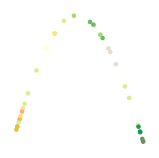

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(1,1, figsize=(1.8, 1.8))
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=Y_phate_df.loc[:, "EGF_WNT_Ratio"],
    cmap=colours,
    ticks=True,
    s=5,
    label_prefix="PHATE",
    legend=False,
    fontsize=7,
    ax=ax,
)
fig.axis("off")

### CLU, SURVIVIN, Pan-CK, and pRB [S801/811]

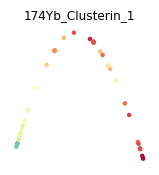

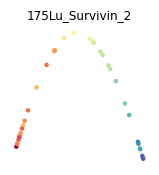

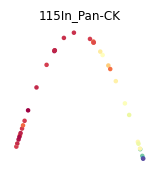

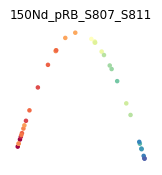

<IPython.core.display.Javascript object>

In [28]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2", "115In_Pan-CK", "150Nd_pRB_S807_S811"]:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PHATE_WNT-EGF-Gradient_{marker}.pdf",
    #     bbox_inches="tight",
    #     )


## PCA

In [29]:
# ---
# PCA
# ---

pca = PCA(n_components=2)
pca.fit(dr_matrix)

Y_pca = pca.transform(dr_matrix)
pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)  # %variance explained
pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)

# Join PCA coordinates with EMD dataframe
Y_pca_df = pd.DataFrame(Y_pca).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_pca_df = pd.merge(emd_df_master_wide, Y_pca_df, on="index")
Y_pca_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_pca_df.head()

,batch,barcode,treatment_1,reagent_1,concentration_1,treatment_2,reagent_2,concentration_2,replicate,culture,...,174Yb_Clusterin_1,175Lu_Survivin_2,176Yb_FABP2,191Ir_DNA 1,193Ir_DNA 2,194Pt_Cisplatin,209Bi_DiMeHH3_K4,89Y_pHH3_S28,0,1
0,B1,1,WNT-0,WNT,0,EGF-0,EGF,0,1,WNT-0_EGF-0,...,-0.191280,-0.031790,-0.058681,-0.047304,-0.046100,-0.143317,-0.118408,0.017210,0.423565,0.712263
1,B1,2,WNT-0,WNT,0,EGF-0,EGF,0,2,WNT-0_EGF-0,...,0.061850,0.023246,0.073919,0.053632,0.055607,0.128847,0.098753,0.015404,0.297748,0.442836
2,B1,3,WNT-0,WNT,0,EGF-0,EGF,0,3,WNT-0_EGF-0,...,0.178683,0.020712,0.067817,0.044777,0.043871,0.053291,0.070116,0.010988,0.435564,0.293569
3,B1,7,WNT-100,WNT,100,EGF-0,EGF,0,1,WNT-100_EGF-0,...,0.667126,-0.204921,-0.374759,-0.040943,-0.039763,-0.639508,-0.598422,0.065094,1.345919,0.084937
4,B1,8,WNT-100,WNT,100,EGF-0,EGF,0,2,WNT-100_EGF-0,...,0.677499,-0.184424,-0.447293,-0.079882,-0.076649,-0.482239,-0.589128,0.054427,1.261203,0.037474


<IPython.core.display.Javascript object>

### WNT-EGF Ratio

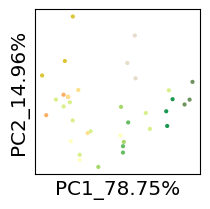

<IPython.core.display.Javascript object>

In [30]:
fig = scprep.plot.scatter2d(
    Y_pca_df.iloc[:, -2:],
    c=Y_pca_df.loc[:, "EGF_WNT_Ratio"],
    cmap=colours,
    ticks=False,
    xlabel=f"PC1_{pc1}%",
    ylabel=f"PC2_{pc2}%",
    s=4,
    legend=False,
    figsize=(2.2, 2.2),
)   

### CLU, SURVIVIN, Pan-CK, and pRB [S801/811]

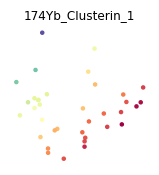

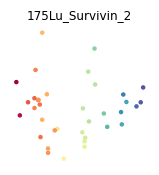

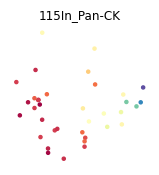

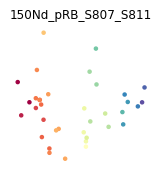

<IPython.core.display.Javascript object>

In [31]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2", "115In_Pan-CK", "150Nd_pRB_S807_S811"]:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")
